# Interpreting the trained transformers

## Setting up

In [70]:
import interp as ip
import tsfm
import matplotlib.pyplot as plt
import sklearn
import os
import torch as t
import circuitsvis as cv

In [ ]:
# load the trained model
directory = "C:/Users/15896/myenv/Hydra/mech_interp_capstone/data/Toyweights"
models = ip.batch_load_model(directory)

## Evaluation of trained models

In this section, we calculate and plot the test loss along the training path and verify that the transformer architecture converges.

c:\Users\15896\myenv\Hydra\mech_interp_capstone\src\interp.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_data = t.load(os.path.join(loss_dir, loss_filename))


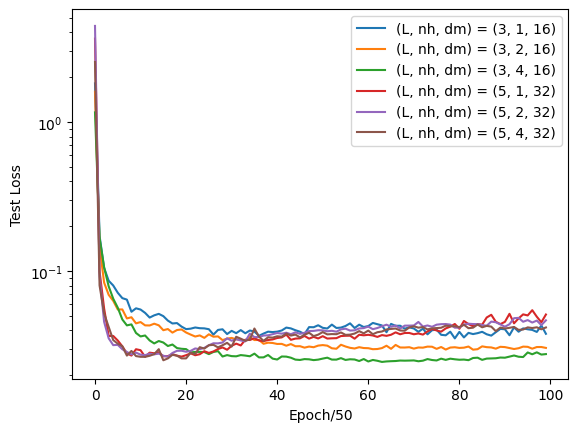

In [101]:
## Plotting the loss of data for larger models

loss_key = 'test_losses'
for filename in os.listdir(directory):
    dat = ip.parse_filename(filename, get_loss_data=True)
    
    # plot for larger datasets
    if dat["n_samples"] == 5000:
        plt.plot(dat[loss_key], label=f"(L, nh, dm) = ({dat['n_layers']}, {dat['n_heads']}, {dat['d_model']})")

plt.xlabel("Epoch/50")
plt.ylabel("Test Loss")

plt.legend()
plt.yscale("log")

We find that

1. Increasing the number of the attention heads slightly improves the performance when $d_\mathrm{model} = 16$, while hardly have any visible effect in the case $d_\mathrm{model} = 32$.
2. The optimal number of parameters seems to be at $d_\mathrm{model} = 16$, as the test loss bounce back due to potential overfitting when we use $d_\mathrm{model} = 32$.


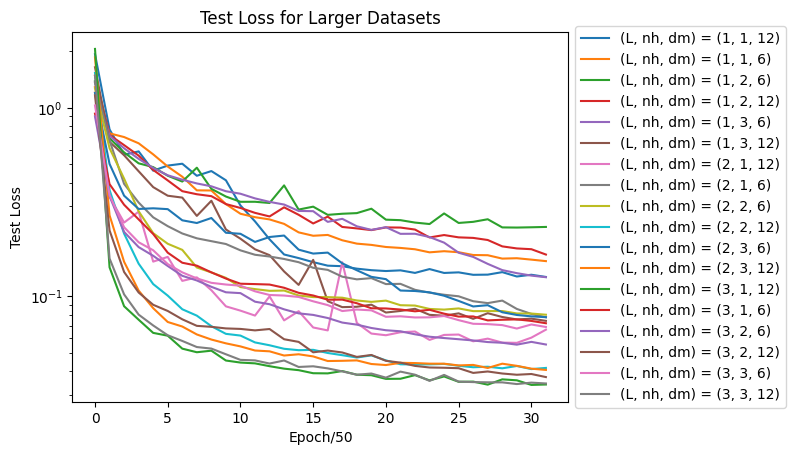

In [12]:
## We also plot for some early training of smaller models

loss_key = 'test_losses'
for filename in os.listdir(directory):
    dat = ip.parse_filename(filename, get_loss_data=True)
    
    # plot for larger datasets
    if dat["n_samples"] == 1600:
        plt.plot(dat[loss_key], label=f"(L, nh, dm) = ({dat['n_layers']}, {dat['n_heads']}, {dat['d_model']})")

plt.xlabel("Epoch/50")
plt.ylabel("Test Loss")
plt.title("Test Loss for Larger Datasets")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")

We save good and bad (relatively speaking) models separately.

In [16]:
## Specifically choosing several the good/bad model for interpretation
## NOTE: In the future,we should employ a grid search method to study all possible models with different set of architecture parameters

# Some bad models (shallow/low layer models)
# (layer, n_head, d_model) = (1, 12, 2)
# (layer, n_head, d_model) = (1, 6, 2)

# Some good models
# (layer, n_head, d_model) = (3, 12, 1)
# (layer, n_head, d_model) = (3, 12, 2)
# (layer, n_head, d_model) = (3, 6, 1)

good_models = {}
good_models[(3, 12, 1)] = models[(3, 12, 1)]
good_models[(3, 12, 2)] = models[(3, 12, 2)]
good_models[(3, 6, 1)] = models[(3, 6, 1)]

bad_models = {}
bad_models[(1, 12, 2)] = models[(1, 12, 2)]
bad_models[(1, 6, 2)] = models[(1, 6, 2)]

## The attention patterns

The pattern is such that good model with many layers ends up concentrate the attention to the first few tokens (inputs) specifically at later stages.

The general observation is

- For multiple-layer models with good test losses, the final attention layer tends to have localized attention near the starting points.
- For single-layer models, this feature is less manifest.

This has lent us an appealing interpretation that, if we feed in the transformer some data following some strict periods, the trained model is able to attribute the attention weights to the first few datapoints and deduce the period from there. In other words, during the training process the transformer learnt that the data comes with a promise that it's evolution is strictly periodic. Then it spontaneously concentrates on 

In [131]:
# Consider one of the good models
# reminder of indices (layer, d_model, n_head)
model = good_models[(3, 12, 1)]
model = bad_models[(1, 6, 2)]
model = models[(1, 12, 2)]

samples, omegas, times = ip.data_generator(1000, 64)

# sort the samples by the omega * dt
phase = omegas * times[:, 1]
sort_idx = phase.argsort()
phase = phase[sort_idx]
samples = samples[sort_idx]
times = times[sort_idx]

# pred, cache = model.run_with_cache(samples)
# choose a sample near start
print(phase)

tensor([3.2957e-05, 9.6582e-03, 1.5277e-02,  ..., 6.2783e+00, 6.2786e+00,
        6.2807e+00])


In [133]:
idx = 500
sample = samples[idx]
phase = omegas[idx] * times[idx, 1] / (2 * t.pi)
pred, cache = model.run_with_cache(sample.unsqueeze(0))


print(f"Visualizing Attention Patterns, one-step phase {phase.detach().numpy():.3g} * 2pi")
for lyr in range(1):
    attn_pattern = cache["pattern", lyr].squeeze(0)
    display(
        cv.attention.attention_patterns(
            tokens=[str(i) for i in range(attn_pattern.shape[1])],
            attention=attn_pattern,
        )
    )
    

Visualizing Attention Patterns, one-step phase 0.953 * 2pi


We ask the following question: How fast does the model learn the periodicity information/the matrix exponential information?

In [53]:
ctx = 6
reverse=True
# generate samples according to context window
samples, omegas, times = ip.data_generator(
    num_samples=200,
    seq_len=ctx,
)

period_targets = ip.generate_periodicity_targets(samples, omegas, times)

# compute the goodness of encoding of the periodicity
r2_dict_good = ip.maxR2_models(
    model_list=good_models,
    target=period_targets,
    samples=samples,
    reverse=reverse,
    trunc=None,
    alpha=1.0
)
r2_dict_bad = ip.maxR2_models(
    model_list=bad_models,
    target=period_targets,
    samples=samples,
    reverse=reverse,
    trunc=None,
    alpha=1.0
)
r2_dict_good.__len__()

3

In [66]:
def learn_period(model_list, reverse=True, alpha=1.0):
    data = t.zeros(model_list.__len__(), 50)
    # labels = model_list.keys()
    for ctx in range(1, 51):
        samples, omegas, times = ip.data_generator(
            num_samples=200,
            seq_len=ctx,
        )
        
        period_targets = ip.generate_periodicity_targets(samples, omegas, times)
        
        r2_dict = ip.maxR2_models(
            model_list=model_list,
            target=period_targets,
            samples=samples,
            reverse=reverse,
            trunc=None,
            alpha=alpha
        )
        
        for i, key in enumerate(r2_dict.keys()):
            data[i, ctx-1] = r2_dict[key][0]
            
            
    
    return data



Text(0, 0.5, 'Goodness (R2-value) of Encoding Periodicity')

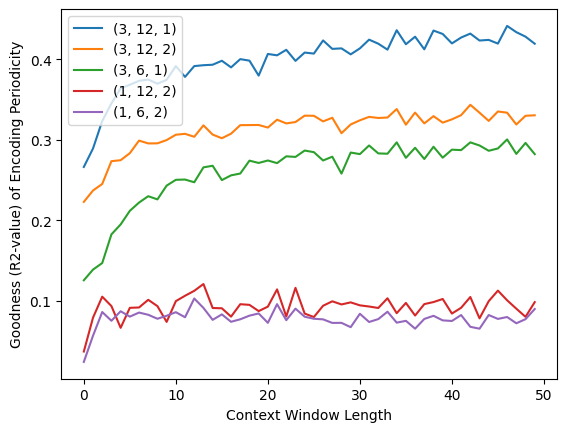

In [63]:
good_data = learn_period(good_models)
bad_data = learn_period(bad_models)

plt.plot(good_data.T, label=good_models.keys())
plt.legend()

plt.plot(bad_data.T, label=bad_models.keys())
plt.legend()

plt.xlabel("Context Window Length")
plt.ylabel("Goodness (R2-value) of Encoding Periodicity")


c:\Users\15896\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.54488e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Text(0, 0.5, 'Goodness (R2-value) of Encoding Periodicity')

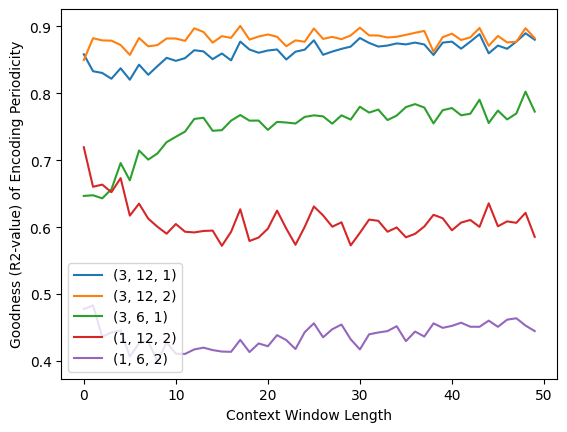

In [68]:
good_data = learn_period(good_models, reverse=False, alpha=5.0)
bad_data = learn_period(bad_models, reverse=False, alpha=5.0)

plt.plot(good_data.T, label=good_models.keys())
plt.legend()

plt.plot(bad_data.T, label=bad_models.keys())
plt.legend()

plt.xlabel("Context Window Length")
plt.ylabel("Goodness (R2-value) of Encoding Periodicity")

The interpretation for this graph should be that good models learns 